In [1]:
import networkx as nx
import pandas as pd
import ast
import matplotlib.pyplot as plt
from pbpstats.client import Client
from nba_api.stats.endpoints import commonteamroster, leaguelineupviz
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Read dictionary with team_ids' three-letter abbreviations as keys and team IDs as values
with open('team_ids.txt','r') as data: 
    contents = data.read()

team_name_dict = ast.literal_eval(contents)
data.close()

team_ids_dict = {v:k for k,v in team_name_dict.items()}

# Set up settings for reading play-by-play data from local files
settings = {
    "dir": "response_data",
    "Games": {"source": "file", "data_provider": "data_nba"},
    "Possessions": {"source": "file", "data_provider": "stats_nba"},
    "EnhancedPbp": {"source": "file", "data_provider": "stats_nba"}
}

client = Client(settings)
team_ids = list(team_name_dict.values())
s = client.Season("nba", "2021", "Regular Season")


In [3]:
from nba_api.stats.endpoints import teamgamelogs

g = teamgamelogs.TeamGameLogs(team_id_nullable=team_name_dict['OKC'],season_nullable="2021-22")
games = g.get_data_frames()[0]
games.iloc[39:42]

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
39,2021-22,1610612760,OKC,Oklahoma City Thunder,0022100663,2022-01-17T00:00:00,OKC @ DAL,L,48.0,36,...,54,56,32,14,66,50,69,23,41,26
40,2021-22,1610612760,OKC,Oklahoma City Thunder,0022100646,2022-01-15T00:00:00,OKC vs. CLE,L,48.0,36,...,16,70,53,75,29,16,59,74,41,34
41,2021-22,1610612760,OKC,Oklahoma City Thunder,0022100630,2022-01-13T00:00:00,OKC @ BKN,W,48.0,47,...,76,2,15,29,11,77,48,23,2,1


In [ ]:
# Load the data for all the games in the season
s = client.Season("nba", "2021", "Regular Season")

season = s.games.items
games = [client.Game(g.game_id) for g in season]

# Sort the games in the season by date
games.sort(key=lambda x: next(( item['date'] for item in s.games.data if item["game_id"] == x.game_id ), None))


In [93]:
# Create game-by-game scoring networks

# For each team
for t in team_ids:

    # Get the ID and name of each player on the team
    r = commonteamroster.CommonTeamRoster(season="2021", team_id=t)
    roster = r.get_data_frames()[0]
    roster = roster[['PLAYER_ID','PLAYER']]

    IDs = roster['PLAYER_ID'].tolist()
    names = roster['PLAYER'].tolist()

    # Create a list to store the edge weights for each game
    edge_weights_list = []

    # For each game in the season
    for n,game in enumerate(games):
        # If the team was one of the teams in the game
        if game.possessions.items[1].offense_team_id==t or game.possessions.items[2].offense_team_id==t:
            # Create a weighted complete graph with nodes keyed by the team's player's IDs to be the scoring network for the game
            G = nx.complete_graph(IDs)
            nx.set_edge_attributes(G,0,'weight')


            # Add the appropriate weight for each made shot by the team
            for shot in game.enhanced_pbp.fgms:
                if shot.data['team_id'] == t and shot.data["player1_id"] in IDs:
                    shooter = shot.data["player1_id"]
                    for player in shot.current_players[t]:
                        if player != shooter and player in IDs:
                            G[player][shooter]['weight'] += shot.shot_data["ShotValue"]

            # Add the appropriate weight for each made free throw by the team
            for ft in game.enhanced_pbp.ftas:
                if ft.is_made and ft.data['team_id'] == t and ft.data['player1_id'] in IDs:
                    shooter = ft.data["player1_id"]
                    for player in ft.event_for_efficiency_stats.current_players:
                        if player != shooter and player in IDs:
                            G[player][shooter]['weight'] += 1

            # Get the date of the game
            game_date = next(( item['date'] for item in s.games.data if item["game_id"] == game.game_id ), None)
            edge_weights_list.append([team_ids_dict[t],t,game_date] + [d for u,v,d in G.edges.data('weight')])
    
    # Create a dataframe for the team with a column for each pair of players
    df = pd.DataFrame(columns=['TEAM_NAME', 'TEAM_ID', 'GAME_DATE'] + list(G.edges()), data=edge_weights_list)

    # Save the edge weights for each pair of players in each game to a csv file
    df.to_csv(f'Rolling Totals/{team_ids_dict[t]}_game-by-game_graphs.csv')

In [21]:
s.games.items[668].data
next(( item['date'] for item in s.games.data if item["game_id"] == a.game_id ), None)

'2022-04-07'

In [28]:
#a = client.Game('0022101196')
data = []
for i in range(82):
    data.append([i,i+1,i+2,i+3,i+4])

df = pd.DataFrame(data)
df

,0,1,2,3,4
0,0,1,2,3,4
1,1,2,3,4,5
2,2,3,4,5,6
3,3,4,5,6,7
4,4,5,6,7,8
...,...,...,...,...,...
77,77,78,79,80,81
78,78,79,80,81,82
79,79,80,81,82,83
80,80,81,82,83,84


In [33]:
df2 = pd.DataFrame(columns=df.columns)
for i in range(82-15):
    s2 = df.iloc[(0+i):(15+i),:].sum(axis=0)
    df2 = pd.concat([df2,s2.to_frame(i+16).T])
df2.iloc[16,3]

390

In [2]:
# Build dataframes for the 15-game moving average scoring networks

# Dictionary with team IDs as keys and dataframes with 15-game rolling average edge weights as values
frames = {}

# For each team
for t in team_ids:

    # Read in the team's game-by-game scoring networks
    df = pd.read_csv(f'Rolling Totals/{team_ids_dict[t]}_game-by-game_graphs.csv', index_col=0)

    # Create a new dataframe to hold the edge weights in 15-game intervals
    df2 = pd.DataFrame(columns=list(df.columns[0:2]) + ['START_DATE','END_DATE'] + list(df.columns[3:]))

    # For each game after the 15th game
    for i in range(82-15):
        # Sum the edge weights for the last 15 games
        s2 = df.iloc[(0+i):(15+i),3:].sum(axis=0)
        # Get the start and end dates for the interval
        s1 = pd.Series({'TEAM_NAME':team_ids_dict[t],'TEAM_ID':t,'START_DATE':df.iloc[(0+i), 2],'END_DATE':df.iloc[(15+i), 2]})

        # Add the data to the appropriate dataframe
        sum_data = pd.concat([s1,s2])
        df2 = pd.concat([df2,sum_data.to_frame(i+16).T])
    
    frames[t] = df2


In [103]:
sum_data

TEAM_NAME                    MIA
TEAM_ID               1610612748
START_DATE            2022-03-09
END_DATE              2022-04-10
(1629216, 203506)              0
                         ...    
(1629622, 1629130)            20
(1629622, 1630209)            24
(2617, 1629130)                5
(2617, 1630209)                6
(1629130, 1630209)            35
Length: 140, dtype: object

In [84]:
# Use to approxixmate how many minutes each lineup played;
# Divide edge weights by minutes per game;
# ------------- Not implemented currently
from nba_api.stats.endpoints import leaguedashlineups

l = leaguedashlineups.LeagueDashLineups(2,season='2021-22', rank='N',team_id_nullable=t,per_mode_detailed='PerGame')
line = l.get_data_frames()[0]

In [32]:
# Define function for getting various network metrics from a weighted graph

import networkx as nx
from networkx.algorithms import approximation

columns = ['TEAM', 'TEAM_ID', 'START_DATE', 'END_DATE', 'AVERAGE_CLUSTERING', 'S_METRIC', 
        'GLOBAL_EFFICIENCY', 'LOCAL_EFFICIENCY', 'CLIQUE_NUMBER',
        'NODE_CONNECTIVITY', 'STOER_WAGNER', 'AVERAGE_CORE_NUMBER',
        'DEGREE_ASSORTATIVITY_COEFFICIENT', 'RANDOMIZED_PARTITIONING',
        'ONE_EXCHANGE', 'ESTRADA_INDEX', 'PROMINENT_GROUP_CENTRALITY',
        'AVERAGE_NODE_CONNECTIVITY', 'AVERAGE_DEGREE_CONNECTIVITY']

def getNetWorkMetrics(g):
    metrics = []
    metrics.append(nx.average_clustering(g))
    metrics.append(nx.s_metric(g, normalized=False))
    #metrics.append(nx.non_randomness(g, weight='weight'))
    #print(1)
    metrics.append(nx.global_efficiency(g))
    metrics.append(nx.local_efficiency(g))
    metrics.append(nx.graph_clique_number(g))
    #print(2)
    metrics.append(nx.node_connectivity(g))
    #metrics.append(nx.stoer_wagner(g, weight='weight')[0])
    metrics.append("")
    core = nx.core_number(g).values()
    metrics.append(sum(core)/len(core))
    #print(3)
    metrics.append(nx.degree_assortativity_coefficient(g, weight='weight'))
    met1 = []
    met2 = []
    for i in range(75):
        met1.append(approximation.randomized_partitioning(g, weight='weight')[0])
        met2.append(approximation.one_exchange(g, weight='weight')[0])
    metrics.append(sum(met1)/len(met1))
    #print(4)
    metrics.append(sum(met2)/len(met2))
    metrics.append(nx.estrada_index(g))
    #metrics.append(nx.prominent_group(g, weight='weight',k=8,greedy=True, normalized=False)[0])
    metrics.append("")
    #print(5)
    metrics.append(nx.average_node_connectivity(g))
    #metrics.append(nx.sigma(g,nrand=5,niter=25))
    met3 = nx.average_degree_connectivity(g, weight='weight').values()
    metrics.append(sum(met3)/len(met3))

    return metrics

In [19]:
x = list(team_ids)[18]
df2 = frames[t]
r = commonteamroster.CommonTeamRoster(season="2021", team_id=t)
roster = r.get_data_frames()[0]
roster = roster[['PLAYER_ID','PLAYER']]

IDs = roster['PLAYER_ID'].tolist()
H = nx.complete_graph(IDs)
stats_dict = {eval(k):v for k,v in df2.iloc[53,2:].to_dict().items()}
nx.set_edge_attributes(H,stats_dict,name='weight')
zero_edges = [e for e in H.edges(data=True) if e[2]['weight'] == 0]
# Remove edges with 0 weight
H.remove_edges_from(zero_edges)
#Remove edges for players who didn't play
H.remove_nodes_from(list(nx.isolates(H)))

In [ ]:


for t in team_ids[:22]:
    df2 = frames[t]
    df15 = pd.DataFrame(columns=columns)
    
    r = commonteamroster.CommonTeamRoster(season="2021", team_id=t)
    roster = r.get_data_frames()[0]
    roster = roster[['PLAYER_ID','PLAYER']]

    IDs = roster['PLAYER_ID'].tolist()

    for j in range(len(df2.index)):
        H = nx.complete_graph(IDs)
        stats_dict = {eval(k):v for k,v in df2.iloc[j,4:].to_dict().items()}
        nx.set_edge_attributes(H,stats_dict,name='weight')
        zero_edges = [e for e in H.edges(data=True) if e[2]['weight'] == 0]
        # Remove edges with 0 weight
        H.remove_edges_from(zero_edges)
        #Remove edges for players who didn't play
        H.remove_nodes_from(list(nx.isolates(H)))
        df15 = pd.concat([df15,pd.Series(list(df2.iloc[j,0:4]) + getNetWorkMetrics(H),
                    index=columns).to_frame(j+15).T])
        if j%12==0:
            print(j)
    
    df15.to_csv(f'Rolling Totals/{team_ids_dict[t]}_rolling_metrics.csv')
    print(team_ids_dict[t])


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df15_dict = {}
for t in team_ids:
    df15_dict[t] = pd.read_csv(f'Rolling Totals/{team_ids_dict[t]}_rolling_metrics.csv')

In [75]:
# Define function for subtracting the away team's metrics from the home team's metrics


def calculateMetricDifference(row):
    date = row['GAME_DATE']
    home_metrics = df15_dict[row['TEAM_ID']].iloc[(df15_dict[row['TEAM_ID']]['END_DATE'] == date).to_list(), 5:].squeeze()
    away_metrics = df15_dict[row['TEAM_ID2']].iloc[(df15_dict[row['TEAM_ID2']]['END_DATE'] == date).to_list(), 5:].squeeze()
    return home_metrics.subtract(away_metrics).to_dict()

def bothTeamsMetrics(row):
    date = row['GAME_DATE']
    home_metrics = df15_dict[row['TEAM_ID']].iloc[(df15_dict[row['TEAM_ID']]['END_DATE'] == date).to_list(), 5:].squeeze()
    away_metrics = df15_dict[row['TEAM_ID2']].iloc[(df15_dict[row['TEAM_ID2']]['END_DATE'] == date).to_list(), 5:].squeeze()
    
    try:
        home_metrics[0]
        return pd.concat([home_metrics,away_metrics]).reset_index(drop=True).to_dict()
    except:
        return {i:0 for i in range(15*2)}

def ln_no_sign(val):
    if np.sign(val) < 0:
        return -1 * np.log(-1*val)
    elif np.sign(val) > 0:
        return np.log(val)
    else:
        return 0

In [96]:
# Create dataframe with independent variables (difference in scoring network metrics) and dependent variable (result of game)

from nba_api.stats.endpoints import leaguegamelog


# Get the teams, winner, and margin of victory for each matchup in the season
le = leaguegamelog.LeagueGameLog(season='2021-22')
game_results = le.get_data_frames()[0]
game_results = game_results[game_results['MATCHUP'].str.contains('vs.')].reset_index(drop=True)
game_results = game_results.loc[:,['SEASON_ID','TEAM_ID','TEAM_ABBREVIATION','GAME_ID','GAME_DATE','MATCHUP','WL','MIN','PLUS_MINUS']]
game_results.insert(3, 'TEAM_ABBREVIATION2', game_results['MATCHUP'].str[-3:])
game_results.insert(3, 'TEAM_ID2', game_results['TEAM_ABBREVIATION2'].apply(lambda x: team_name_dict[x]))
game_results['WL'] = game_results['WL'].map({'W': 1, 'L': 0})

# For each game, calculate the difference between opposing teams' scoring network metrics
game_results = pd.concat([game_results,game_results.apply(calculateMetricDifference, axis=1,result_type='expand')],axis=1)

# Filter out games where there were no 15-game scoring networks
game_results = game_results.where(game_results.astype(bool),0)
game_results = game_results[(game_results.iloc[:,-(len(columns)-4):]==0).sum(1) < 10]

In [97]:
# Logistic Regression - statsmodels

model_data = pd.concat([game_results['WL'],game_results.iloc[:,-(len(columns)-4):]],axis=1)
model_data = model_data.dropna(axis=1,how='all')
model_data = model_data.astype(float)
model_data = sm.add_constant(model_data,prepend=False)

# Normalize columns with very large values using natural logarithm
#model_data['S_METRIC'] = model_data['S_METRIC'].apply(ln_no_sign)
model_data['ESTRADA_INDEX'] = model_data['ESTRADA_INDEX'].apply(ln_no_sign)

accuracy_list = []
for i in range(50):
    train, test = train_test_split(model_data, train_size=0.75)

    model = sm.Logit(train['WL'],train.iloc[:,1:]).fit()
    #model.summary()

    yhat = model.predict(test.iloc[:,1:])
    predicted = list(map(round, yhat))

    obvious_yhat = yhat[(yhat > 0.60) | (yhat <0.4)]
    obvious_predicted = list(map(round, obvious_yhat))
    obvious_test = test['WL'].loc[list(obvious_yhat.index)]
    #accuracy_list.append(accuracy_score(test['WL'], predicted))
    accuracy_list.append(accuracy_score(obvious_test, obvious_predicted))

print("Acuracy: ", sum(accuracy_list)/len(accuracy_list))


Optimization terminated successfully.
         Current function value: 0.658869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658378
  

In [99]:
# Logistic Regression - sklearn

model_data = pd.concat([game_results['WL'],game_results.iloc[:,12:]],axis=1)
model_data = model_data.dropna(axis=1,how='all')
model_data = model_data.astype(float)
#model_data = sm.add_constant(model_data,prepend=False)

# Normalize columns with very large values using natural logarithm
#model_data['S_METRIC'] = model_data['S_METRIC'].apply(ln_no_sign)
#model_data['ESTRADA_INDEX'] = model_data['ESTRADA_INDEX'].apply(ln_no_sign)



accuracy_list = []
for i in range(100):
    min_max_scaler = MinMaxScaler()

    train, test = train_test_split(model_data, train_size=0.9)
    train = min_max_scaler.fit_transform(train)
    test = min_max_scaler.transform(test)

    model = LogisticRegression(C=1, penalty='l2', solver='liblinear').fit(train[:,1:],train[:,0])
    #model.summary()

    yhat = model.predict(test[:,1:])
    predicted = list(map(round, yhat))

    accuracy_list.append(accuracy_score(test[:,0], predicted))

print("Acuracy: ", sum(accuracy_list)/len(accuracy_list))

Acuracy:  0.5840000000000001


In [100]:
# Linear Regression

model_data = pd.concat([game_results['PLUS_MINUS'],game_results.iloc[:,-(len(columns)-4):]],axis=1)
model_data = model_data.dropna(axis=1,how='all')
model_data = model_data.astype(float)
model_data = sm.add_constant(model_data,prepend=False)

# Normalize columns with very large values using natural logarithm
#model_data['S_METRIC'] = model_data['S_METRIC'].apply(ln_no_sign)
#model_data['ESTRADA_INDEX'] = model_data['ESTRADA_INDEX'].apply(ln_no_sign)


train, test = train_test_split(model_data, train_size=0.75)

model = sm.OLS(train['PLUS_MINUS'],train.iloc[:,1:]).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6.137
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           5.44e-11
Time:                        17:42:25   Log-Likelihood:                -3088.5
No. Observations:                 749   AIC:                             6205.
Df Residuals:                     735   BIC:                             6270.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
AVERAGE_CLUSTERING                 -13.4323     37.871     -0.355      0.723     -87.781      60.917
S_METRIC                             0.0007      0.001      1.068      0.286      -0.001       0.002
GLOBAL_EFFICIENCY                   41.6452     43.207      0.964      0.335     -43.179     126.470
LOCAL_EFFICIENCY                    12.5297     39.606      0.316      0.752     -65.225      90.285
CLIQUE_NUMBER                       -2.5402      0.746     -3.406      0.001      -4.004      -1.076
NODE_CONNECTIVITY                    0.4454      0.360      1.237      0.216      -0.261       1.152
AVERAGE_CORE_NUMBER                  5.7748      1.431      4.036      0.000       2.966       8.584
DEGREE_ASSORTATIVITY_COEFFICIENT     4.7482      5.730      0.829      0.408      -6.500      15.997
RANDOMIZED_PARTITIONING              0.0112      0.006      1.825      0.068      -0.001       0.023
ONE_EXCHANGE                        -0.0039      0.005     -0.758      0.449      -0.014       0.006
ESTRADA_INDEX                    -5.212e-07    9.5e-06     -0.055      0.956   -1.92e-05    1.81e-05
AVERAGE_NODE_CONNECTIVITY           -6.6015      2.317     -2.849      0.005     -11.151      -2.052
AVERAGE_DEGREE_CONNECTIVITY          0.3648      1.265      0.288      0.773      -2.119       2.848
const                                1.7349      0.555      3.128      0.002       0.646       2.824
==============================================================================
Omnibus:                        7.430   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               10.270
Skew:                           0.054   Prob(JB):                      0.00589
Kurtosis:                       3.564   Cond. No.                     1.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
pred = model.predict(test.iloc[:,1:])
pred.subtract(test['PLUS_MINUS']).mean()


0.06874752401484908

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df15_dict = {}
for t in team_ids:
    df15_dict[t] = pd.read_csv(f'Rolling Totals/{team_ids_dict[t]}_rolling_metrics.csv')

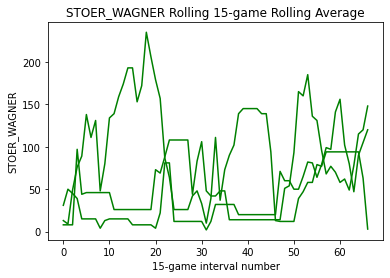

In [74]:
"""plt.plot(df15['AVERAGE_NODE_CONNECTIVITY'])
plt.plot(df15['AVERAGE_DEGREE_CONNECTIVITY'])
plt.ylim(0,14)"""
x = 8

for t in list(team_ids)[15:25]:
    plt.plot(df15_dict[t][df15.columns[x]],'g')
plt.title(f'{df15.columns[x]} Rolling 15-game Rolling Average')
plt.xlabel('15-game interval number')
plt.ylabel(df15.columns[x])


plt.show()

In [37]:
print(games[0].possessions.items[1].offense_team_id)
games[0].possessions.items[2].offense_team_id

1610612749


1610612740